# Autoencoder Approach to Feature Classification
The following is an attempt to improve the previous author's neural network classification approach by using autoencoders.  
The code from the original neural network approach can be found in the file "prepare_raw_data.py".  
It was copied into this jupyter notebook and updated to use Python 3.7 and Tensorflow 2 (which includes Keras).

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import numpy as np
import tensorflow as tf
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy',
           keras.metrics.TruePositives(),
           keras.metrics.FalsePositives(),
           keras.metrics.TrueNegatives(),
           keras.metrics.FalseNegatives()]

In [2]:
np.random.seed(4)
tf.random.set_seed(2)

This is the original author's code, just copied into separate cells of this jupyter notebook:

In [3]:
def get_busy_vs_relax_timeframes(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)
        try:
            tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 1))
            tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 0))
        except ValueError:
            continue
#             print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [4]:
def get_engagement_increase_vs_decrease_timeframes(path, ident, seconds):
    """Returns raw data from either engagement 'increase' or 'decrease' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds * samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### engagement increase / decrease
        if task_num_table == 0:
            continue
        mid = int((relax_n[task_num_table][0] + relax_n[task_num_table][1])/2)
        length = int(samp_rate*30)
        for j in range(10):
            new_end = int(mid-j*samp_rate)

            new_start2 = int(mid+j*samp_rate)

            dataextract_decrease = dataextractor.DataExtractor(data[0][new_end - length:new_end],
                                                               data[1][new_end-length:new_end],
                                                               samp_rate)

            dataextract_increase = dataextractor.DataExtractor(data[0][new_start2: new_start2 + length],
                                                               data[1][new_start2: new_start2 + length], samp_rate)

            try:
                tasks_data = np.vstack((tasks_data, dataextract_increase.y))
                tasks_y = np.vstack((tasks_y, 1))
                tasks_data = np.vstack((tasks_data, dataextract_decrease.y))
                tasks_y = np.vstack((tasks_y, 0))
            except ValueError:
                print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [5]:
def get_task_complexities_timeframes(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [6]:
def get_TLX_timeframes(path, ident, seconds):
    """Returns raw data along with task load index class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task load index
        if cog_res['task_complexity'][task_num_table] == 'medium' or cog_res['task_label'][task_num_table] != 'PT':
            continue
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, cog_res['task_load_index'][task_num_table]))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [7]:
def get_data_from_idents(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    for i in idents:
        x, y = get_busy_vs_relax_timeframes(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
        # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
        # TODO: ^ modify, so that different functions can be accessible by parameter
        data = np.vstack((data, x))
        ys = np.vstack((ys, y))
    return data, ys


In [8]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    print('Train...')
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    print('Evaluate...')
    score = model.evaluate(x_test, y_test, batch_size=batch_size)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [9]:
def sequence_padding(x, maxlen):
    """Pad sequences (all have to be same length)."""
    print('Pad sequences (samples x time)')
    return sequence.pad_sequences(x, maxlen=maxlen, dtype=np.float)


# Preparing the Data and Autoencoder

### Prepare the Data
Read the data from files and store it into arrays.

In [10]:
# Mostly a copy of the code in __main__(), used for reading the data into an array
seconds = 30  # time window length
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'

train_idents = idents[:-8]
validation_idents = idents[-8:]
test_idents = [idents[-2]]

x_train, y_train = get_data_from_idents(path, train_idents, seconds)
x_valid, y_valid = get_data_from_idents(path, validation_idents, seconds)
x_test, y_test = get_data_from_idents(path, test_idents, seconds)

print("x_train shape:", x_train.shape, "  x_test shape:", x_test.shape)

x_train shape: (486, 1290)   x_test shape: (33, 1290)


### Preprocess the Data
Prepare two versions of the data:
- Normalize original data (**x_\***): reffered to as **normalized data** from now on,
- subsampled, filtered, then normalized data (**x2_\***): reffered to as **shortened data** form now on.

In [11]:
from scipy.ndimage.filters import gaussian_filter1d

step = 4 # take each step-th element of the array
sigma = 2 # sigma for gaussian filter

def convolve(x): # helper function for applying along axis
    tmp = gaussian_filter1d(x, sigma=sigma, mode="mirror")
    tmp = normalize(tmp)
    return tmp

def normalize(x): # helper function for applying along axis
    #normalize the data
    tmp = x
    tmp_min = np.min(tmp)
    tmp_max = np.max(tmp)
    top_norm = tmp-tmp_min
    bot_norm = tmp_max-tmp_min
    if (bot_norm == 0): # avoid division by 0
        bot_norm = 1
    tmp = top_norm/bot_norm
    return tmp

# Prepare another set of data that is subsampled, filtered and normalized
# Use np.apply_along_axis to apply the above function to each row of the array separately
x2_train = x_train[:,1::step]
x2_train = np.apply_along_axis(convolve, 1, x2_train)

x2_valid = x_valid[:,1::step]
x2_valid = np.apply_along_axis(convolve, 1, x2_valid)

x2_test = x_test[:,1::step]
x2_test = np.apply_along_axis(convolve, 1, x2_test)

sscaler = StandardScaler()
sscaler.fit(np.vstack((x2_train, x2_test, x2_valid)))
x2_train = sscaler.transform(x2_train)
x2_valid = sscaler.transform(x2_valid)
x2_test = sscaler.transform(x2_test)

mmscaler = MinMaxScaler()
mmscaler.fit(np.vstack((x2_train, x2_test, x2_valid)))
x2_train = mmscaler.transform(x2_train)
x2_valid = mmscaler.transform(x2_valid)
x2_test = mmscaler.transform(x2_test)

# Normalize original (normalized) data
# Use np.apply_along_axis to apply the above function to each row of the array separately
# x_train = np.apply_along_axis(normalize, 1, x_train)
# x_valid = np.apply_along_axis(normalize, 1, x_valid)
# x_test = np.apply_along_axis(normalize, 1, x_test)

sscaler = StandardScaler()
sscaler.fit(np.vstack((x_train, x_test, x_valid)))
x_train = sscaler.transform(x_train)
x_valid = sscaler.transform(x_valid)
x_test = sscaler.transform(x_test)

mmscaler = MinMaxScaler()
mmscaler.fit(np.vstack((x_train, x_test, x_valid)))
x_train = mmscaler.transform(x_train)
x_valid = mmscaler.transform(x_valid)
x_test = mmscaler.transform(x_test)

print("Normalized data:", x_test.shape, "  Shortened data:", x2_test.shape)

Normalized data: (33, 1290)   Shortened data: (33, 323)


<Figure size 432x288 with 0 Axes>

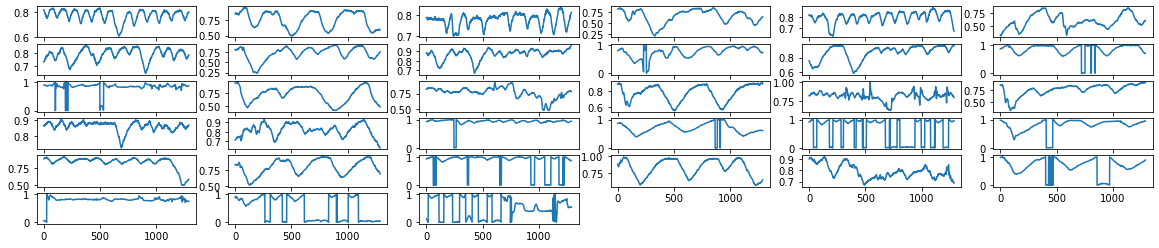

<Figure size 432x288 with 0 Axes>

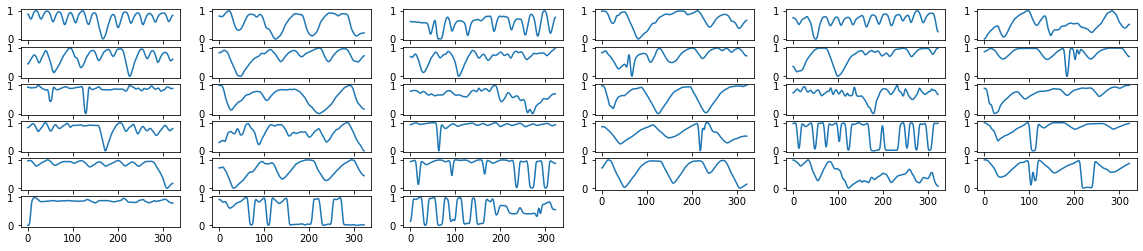

In [12]:
#plot n samples to compare the normalized data to the shortened data
n = 33

#plot some normalized data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])

#plot some shortened data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])

### Prepare a Classifier  
Prepare a function that builds a new model, that will get attached to the encoded part of the autoencoder.  
**Work in progress**

In [13]:
def classifier(model, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 32, dropout = 0.25):
    # Todo: make a better model

    model = layers.Reshape((-1, 1), input_shape=(model.shape)) (model)

    model = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=strides) (model)
    
    model = Dropout(dropout)(model)
    
    model = MaxPooling1D(pool_size=pool_size) (model)
    
    model = Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides) (model)
    
    model = MaxPooling1D(pool_size=pool_size) (model)

    model = LSTM(lstm_output_size, activation='sigmoid') (model)

    model = Dense(1, activation='sigmoid') (model)
    return model

### Deep Autoencoders
from https://blog.keras.io/building-autoencoders-in-keras.html

In [22]:
def deep_ae(x, enc_layers=[512,256], encoding_dim=64, dec_layers=[256,512]):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    encoded_input = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.25, autocast=False)(encoded_input)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(encoded_input, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return autoencoder, encoded

Prepare a version for hyperparameter optimization with talos based on: https://github.com/autonomio/talos

In [15]:
def deep_ae_optimization(x_train, y_train, x_val, y_val, params):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    encoded_input = keras.Input(shape=x_train[0].shape, name="normalized_signal")
    model = Dropout(params['dropout'], name="dropout", autocast=False)(encoded_input)
    for i in enumerate(params['enc_layers']):
        model = Dense(i[1], activation=params['enc_activation'], name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(params['enc_dim'], activation=params['enc_activation'], name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(params['dec_layers'][0], activation=params['enc_activation'], name="dense_dec_1")(encoded_output)
    for i in enumerate(params['dec_layers'][1:]):
        model = Dense(i[1], activation=params['enc_activation'], name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x_train[0].shape[0], activation=params['last_activation'], name="reconstructed_signal")(model)
    
    autoencoder = Model(encoded_input, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])
    
    out = autoencoder.fit(x_train, y_train,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            verbose=0,
            validation_data=[x_val, y_val])
    
    return out, autoencoder

#### Deep Autoencoder - Normalized Input Data

Hyperparameter optimization with Talos:

In [16]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh, binary_crossentropy

p = {'lr': (0.1, 10, 10),
     'enc_dim':[16, 32, 64, 128],
     'batch_size': [16, 64, 128, 256],
     'epochs': [100],
     'dropout': (0, 0.40, 10),
     'optimizer': [Adam, Nadam],
     'enc_layers': [
         [512,256],
         [512],
         [256],
         [256, 128]
     ],
     'dec_layers': [
         [256,512],
         [512],
         [256],
         [128, 256]
     ],
     'loss': ['binary_crossentropy', 'mse'],
     'enc_activation': ['relu', 'sigmoid'],
     'last_activation': ['softmax', 'sigmoid'],
     'weight_regulizer': [None]}

Run the hyperparameter scan:

In [17]:
scan_object = talos.Scan(x_train,
                         x_train, 
                         params=p,
                         model=deep_ae_optimization,
                         experiment_name='deep_ae_normalized',
                         fraction_limit=.001)

  0%|                                                                                          | 0/409 [00:00<?, ?it/s]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


100%|██████████████████████████████████████████████████████████████████████████████| 409/409 [1:04:17<00:00,  9.43s/it]


Access the results through the Scan object:

In [18]:
# access the summary details
scan_object.details

experiment_name        deep_ae_normalized
random_method            uniform_mersenne
reduction_method                     None
reduction_interval                     50
reduction_window                       20
reduction_threshold                   0.2
reduction_metric                  val_acc
complete_time              09/29/20/22:36
x_shape                       (486, 1290)
y_shape                       (486, 1290)
dtype: object

Analyze the Scan results:

In [19]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)
# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,acc,val_loss,val_acc,batch_size,dec_layers,dropout,enc_activation,enc_dim,enc_layers,epochs,last_activation,loss,lr,optimizer,weight_regulizer
0,09/29/20-213207,09/29/20-213218,11.102235,100,0.282215,0.000000,0.309876,0.006849,16,"[128, 256]",0.16,sigmoid,32,"[512, 256]",100,softmax,mse,0.10,<class 'tensorflow.python.keras.optimizer_v2.a...,None
1,09/29/20-213218,09/29/20-213228,9.529829,100,0.077394,0.000000,0.074806,0.006849,64,[512],0.32,sigmoid,16,[256],100,sigmoid,mse,6.04,<class 'tensorflow.python.keras.optimizer_v2.n...,None
2,09/29/20-213228,09/29/20-213236,7.915942,100,0.282204,0.000000,0.309839,0.006849,128,"[256, 512]",0.32,relu,16,[512],100,softmax,mse,0.10,<class 'tensorflow.python.keras.optimizer_v2.n...,None
3,09/29/20-213236,09/29/20-213240,4.303040,100,0.282226,0.002941,0.309873,0.000000,256,[256],0.36,sigmoid,16,"[256, 128]",100,softmax,mse,7.03,<class 'tensorflow.python.keras.optimizer_v2.n...,None
4,09/29/20-213240,09/29/20-213245,4.927633,100,0.077216,0.002941,0.074497,0.006849,256,[256],0.04,relu,128,[512],100,sigmoid,mse,9.01,<class 'tensorflow.python.keras.optimizer_v2.n...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,09/29/20-223559,09/29/20-223604,4.818995,100,0.077202,0.000000,0.074444,0.006849,128,"[256, 512]",0.28,sigmoid,32,"[512, 256]",100,sigmoid,mse,8.02,<class 'tensorflow.python.keras.optimizer_v2.a...,None
405,09/29/20-223604,09/29/20-223609,5.097893,100,3.233116,0.001238,3.484413,0.000887,256,[256],0.08,relu,128,"[256, 128]",100,softmax,binary_crossentropy,0.10,<class 'tensorflow.python.keras.optimizer_v2.n...,None
406,09/29/20-223609,09/29/20-223613,3.749645,100,0.282241,0.000000,0.309861,0.000000,128,[256],0.04,relu,32,[512],100,softmax,mse,0.10,<class 'tensorflow.python.keras.optimizer_v2.a...,None
407,09/29/20-223613,09/29/20-223618,5.128895,100,0.022236,0.002941,0.021813,0.000000,64,[256],0.16,sigmoid,64,"[512, 256]",100,sigmoid,mse,2.08,<class 'tensorflow.python.keras.optimizer_v2.a...,None


Evaluate model:

In [20]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(x_valid, x_valid, folds=10, metric='val_acc', task='multi_label')

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

array([[64, 16, 100, 10.843151092529297, 0.28, 'sigmoid',
        '09/29/20-221644', list([256]), 'softmax', '09/29/20-221655',
        9.01, list([256, 512]),
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, 100,
        None, 0],
       [64, 64, 100, 7.177634239196777, 0.04, 'relu', '09/29/20-222908',
        list([512, 256]), 'softmax', '09/29/20-222915', 2.08,
        list([512]),
        <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 100,
        None, 1],
       [128, 16, 100, 8.032915830612183, 0.2, 'relu', '09/29/20-214443',
        list([512]), 'softmax', '09/29/20-214451', 3.0700000000000003,
        list([256, 512]),
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, 100,
        None, 2],
       [64, 32, 100, 10.68845248222351, 0.16, 'sigmoid',
        '09/29/20-220550', list([256, 128]), 'softmax',
        '09/29/20-220601', 9.01, list([256, 512]),
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, 100,
      

In [22]:
talos.Deploy(scan_object=scan_object, model_name='de_ae_norm_deploy', metric='val_acc');

Deploy package de_ae_norm_deploy have been saved.


Combine the encoder layer and the classification model:  
optimize the classification parameters

In [17]:
p = {'lr': (0.1, 10, 10),
     'batch_size': [16, 64, 128, 256],
     'epochs': [100],
     'dropout': (0, 0.40, 10),
     'optimizer': ['adam', 'nadam'],
     'loss': ['binary_crossentropy'],
     'ker_size': [8,16,24],
     'filters': [8,16,24],
     'strides': [1,2],
     'pool_size': [1,2],
     'lstm_out_size': [8,16,24],
     'weight_regulizer': [None]}

In [24]:
def classification_optimization(x_train, y_train, x_val, y_val, params):

    # AE Training
    autoencoder, encoded = deep_ae(x_train)

#     print("\n\nAUTOENCODER TRAINING: ")
    autoencoder.fit(x_train, x_train,
                batch_size=64,
                epochs=100,
                verbose=0,
                validation_data=[x_val, x_val])

    model = classifier(encoded, kernel_size = params['ker_size'], filters = params['filters'],
                           strides = params['strides'], pool_size = params['pool_size'],
                           lstm_output_size = params['lstm_out_size'], dropout = params['dropout'])

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])

    # Classifier Training
#     print("\n\nCLASSIFICATION TRAINING: ")
    out = model.fit(x_train, y_train,
                batch_size=params['batch_size'],
                epochs=params['epochs'],
                verbose=0,
                validation_data=[x_val, y_val])
    return out, model

In [25]:
scan_object = talos.Scan(x_train,
                         y_train, 
                         params=p,
                         model=classification_optimization,
                         experiment_name='deep_ae_normalized_classif',
                         fraction_limit=.001)

100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [26:42<00:00, 18.63s/it]


In [26]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)
# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,acc,val_loss,val_acc,batch_size,dropout,epochs,filters,ker_size,loss,lr,lstm_out_size,optimizer,pool_size,strides,weight_regulizer
0,09/30/20-113337,09/30/20-113415,37.851594,100,0.572991,0.676471,0.944155,0.431507,16,0.08,100,8,8,binary_crossentropy,2.08,24,nadam,2,1,None
1,09/30/20-113415,09/30/20-113433,17.571790,100,0.649543,0.600000,0.700020,0.527397,256,0.20,100,24,8,binary_crossentropy,5.05,8,nadam,1,1,None
2,09/30/20-113433,09/30/20-113451,17.883959,100,0.670729,0.564706,0.685409,0.541096,256,0.16,100,24,8,binary_crossentropy,2.08,16,nadam,1,1,None
3,09/30/20-113451,09/30/20-113507,16.156457,100,0.551254,0.717647,0.659620,0.664384,128,0.08,100,16,24,binary_crossentropy,5.05,8,adam,1,1,None
4,09/30/20-113508,09/30/20-113544,36.676462,100,0.691667,0.520588,0.697940,0.458904,16,0.00,100,16,16,binary_crossentropy,3.07,8,nadam,1,2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,09/30/20-115906,09/30/20-115920,14.772734,100,0.645696,0.582353,0.701188,0.561644,256,0.32,100,8,24,binary_crossentropy,3.07,16,nadam,1,1,None
82,09/30/20-115921,09/30/20-115934,13.643724,100,0.684611,0.508824,0.688363,0.547945,256,0.36,100,8,24,binary_crossentropy,3.07,16,nadam,2,1,None
83,09/30/20-115934,09/30/20-115949,14.977261,100,0.656486,0.561765,0.693608,0.589041,64,0.00,100,24,16,binary_crossentropy,0.10,8,adam,2,1,None
84,09/30/20-115950,09/30/20-120005,15.928302,100,0.573197,0.676471,0.678451,0.671233,64,0.08,100,16,8,binary_crossentropy,2.08,24,adam,2,1,None


In [27]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(x_valid, y_valid, folds=10, metric='val_acc', task='multi_label')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [28]:
# get the highest result for any metric
analyze_object.high('val_acc')

0.7260273694992065

In [29]:
# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

array([[2, 30.435789585113525, 16, 16, 100, 0.32, 9.01, 2,
        '09/30/20-113925', '09/30/20-113956', 24, 'nadam', None, 16, 100,
        0],
       [2, 11.846956968307495, 24, 256, 100, 0.2, 8.020000000000001, 1,
        '09/30/20-114629', '09/30/20-114641', 8, 'adam', None, 8, 100, 1],
       [1, 16.938929319381714, 24, 256, 100, 0.12, 8.020000000000001, 1,
        '09/30/20-115054', '09/30/20-115111', 24, 'adam', None, 8, 100,
        2],
       [2, 10.684048891067505, 24, 256, 100, 0.36, 5.05, 2,
        '09/30/20-113858', '09/30/20-113908', 24, 'adam', None, 24, 100,
        3],
       [2, 15.92830228805542, 16, 64, 100, 0.08, 2.08, 1,
        '09/30/20-115950', '09/30/20-120005', 24, 'adam', None, 8, 100,
        4],
       [1, 13.275527715682983, 8, 128, 100, 0.32, 3.0700000000000003, 2,
        '09/30/20-115203', '09/30/20-115216', 24, 'adam', None, 16, 100,
        5],
       [1, 14.429283142089844, 16, 256, 100, 0.12, 0.1, 1,
        '09/30/20-114109', '09/30/20-114123', 2

In [30]:
talos.Deploy(scan_object=scan_object, model_name='de_ae_norm_class', metric='val_acc');

Deploy package de_ae_norm_class have been saved.


#### Deep Autoencoder - Shortened Input Data

Hyperparameter optimization with Talos:

In [31]:
p = {'lr': (0.1, 10, 10),
     'enc_dim':[16, 32, 64, 128],
     'batch_size': [16, 64, 128, 256],
     'epochs': [100],
     'dropout': (0, 0.40, 10),
     'optimizer': [Adam, Nadam],
     'enc_layers': [
         [156,128],
         [156],
         [128],
         [156, 128]
     ],
     'dec_layers': [
         [128,156],
         [156],
         [128],
         [128, 156]
     ],
     'loss': ['binary_crossentropy', 'mse'],
     'enc_activation': ['relu', 'sigmoid'],
     'last_activation': ['softmax', 'sigmoid'],
     'weight_regulizer': [None]}

Run the hyperparameter scan:

In [33]:
scan_object = talos.Scan(x2_train,
                         x2_train, 
                         params=p,
                         model=deep_ae_optimization,
                         experiment_name='deep_ae_shortened',
                         fraction_limit=.001)

 15%|████████████▍                                                                    | 63/409 [03:10<16:37,  2.88s/it]

 44%|███████████████████████████████████▌                                            | 182/409 [09:14<11:12,  2.96s/it]

 45%|████████████████████████████████████▍                                           | 186/409 [09:31<14:10,  3.81s/it]

 46%|████████████████████████████████████▉                                           | 189/409 [09:39<10:44,  2.93s/it]

 51%|████████████████████████████████████████▍                                       | 207/409 [10:32<07:50,  2.33s/it]

 55%|███████████████████████████████████████████▊                                    | 224/409 [11:16<06:35,  2.14s/it]

 67%|█████████████████████████████████████████████████████▏                          | 272/409 [13:51<08:14,  3.61s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 378/409 [19:11<02:09,  4.17s/it]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 382/409 [19:26<01:43,  3.84s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 387/409 [19:37<00:52,  2.39s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 400/409 [20:14<00:19,  2.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 409/409 [20:38<00:00,  3.03s/it]


Access the results through the Scan object:

In [34]:
# access the summary details
scan_object.details

experiment_name        deep_ae_shortened
random_method           uniform_mersenne
reduction_method                    None
reduction_interval                    50
reduction_window                      20
reduction_threshold                  0.2
reduction_metric                 val_acc
complete_time             09/30/20/12:21
x_shape                       (486, 323)
y_shape                       (486, 323)
dtype: object

Analyze the Scan results:

In [35]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)
# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,acc,val_loss,val_acc,batch_size,dec_layers,dropout,enc_activation,enc_dim,enc_layers,epochs,last_activation,loss,lr,optimizer,weight_regulizer
0,09/30/20-120054,09/30/20-120056,1.983632,100,0.367187,0.002941,0.349995,0.000000,256,"[128, 156]",0.12,sigmoid,128,"[156, 128]",100,softmax,mse,1.09,<class 'tensorflow.python.keras.optimizer_v2.a...,None
1,09/30/20-120057,09/30/20-120059,2.356578,100,0.690249,0.003451,0.693449,0.003456,128,[156],0.24,sigmoid,64,"[156, 128]",100,sigmoid,binary_crossentropy,7.03,<class 'tensorflow.python.keras.optimizer_v2.n...,None
2,09/30/20-120059,09/30/20-120101,1.796427,100,3.090581,0.003223,2.978866,0.003223,256,[156],0.00,relu,32,"[156, 128]",100,softmax,binary_crossentropy,8.02,<class 'tensorflow.python.keras.optimizer_v2.a...,None
3,09/30/20-120101,09/30/20-120103,1.558388,100,0.690013,0.003469,0.693206,0.003372,256,[128],0.24,sigmoid,16,[156],100,sigmoid,binary_crossentropy,0.10,<class 'tensorflow.python.keras.optimizer_v2.a...,None
4,09/30/20-120103,09/30/20-120108,4.986094,100,3.034803,0.003223,2.936526,0.003223,16,"[128, 156]",0.08,relu,64,[128],100,softmax,binary_crossentropy,1.09,<class 'tensorflow.python.keras.optimizer_v2.a...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,09/30/20-122119,09/30/20-122120,1.496223,100,0.627479,0.003333,0.621252,0.003329,256,[128],0.04,sigmoid,16,[156],100,sigmoid,binary_crossentropy,9.01,<class 'tensorflow.python.keras.optimizer_v2.a...,None
405,09/30/20-122120,09/30/20-122122,2.298877,100,3.056715,0.003223,2.960151,0.003223,64,"[128, 156]",0.36,relu,32,[128],100,softmax,binary_crossentropy,3.07,<class 'tensorflow.python.keras.optimizer_v2.a...,None
406,09/30/20-122123,09/30/20-122127,4.337361,100,0.366024,0.014706,0.348953,0.041096,16,[128],0.24,sigmoid,16,[156],100,softmax,mse,1.09,<class 'tensorflow.python.keras.optimizer_v2.n...,None
407,09/30/20-122127,09/30/20-122128,1.273705,100,0.026662,0.020588,0.031638,0.020548,256,[128],0.08,relu,32,[128],100,sigmoid,mse,1.09,<class 'tensorflow.python.keras.optimizer_v2.a...,None


Evaluate model:

In [36]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(x2_valid, x2_valid, folds=10, metric='val_acc', task='multi_label')

[0.0,
 0.03623188405797101,
 0.022727272727272728,
 0.02127659574468085,
 0.02127659574468085,
 0.022222222222222223,
 0.0,
 0.020833333333333332,
 0.02127659574468085,
 0.014814814814814814]

In [37]:
# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

array([[list([156]), 2.0556814670562744, 64, 'relu', list([156, 128]),
        100, 0.08, 64, 3.0700000000000003, '09/30/20-120700',
        '09/30/20-120702', None,
        <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>,
        'sigmoid', 100, 0],
       [list([156]), 1.9395413398742676, 64, 'relu', list([156, 128]),
        100, 0.2, 64, 1.09, '09/30/20-122115', '09/30/20-122117', None,
        <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>,
        'sigmoid', 100, 1],
       [list([156]), 1.9004690647125244, 128, 'relu', list([128]), 100,
        0.08, 128, 1.09, '09/30/20-120457', '09/30/20-120459', None,
        <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>,
        'softmax', 100, 2],
       [list([128, 156]), 2.8580338954925537, 64, 'relu',
        list([156, 128]), 100, 0.08, 64, 0.1, '09/30/20-122039',
        '09/30/20-122042', None,
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>,
        'sigmoid', 100, 3],
       [list([12

In [38]:
talos.Deploy(scan_object=scan_object, model_name='de_ae_short_deploy', metric='val_acc');

Deploy package de_ae_short_deploy have been saved.


Combine the encoder layer and the classification model:  
optimize the classification parameters

In [39]:
p = {'lr': (0.1, 10, 10),
     'batch_size': [16, 64, 128, 256],
     'epochs': [100],
     'dropout': (0, 0.40, 10),
     'optimizer': ['adam', 'nadam'],
     'loss': ['binary_crossentropy'],
     'ker_size': [8,16,24],
     'filters': [8,16,24],
     'strides': [1,2],
     'pool_size': [1,2],
     'lstm_out_size': [8,16,24],
     'weight_regulizer': [None]}

In [40]:
def classification_optimization(x_train, y_train, x_val, y_val, params):

    # AE Training
    autoencoder, encoded = deep_ae(x_train)

#     print("\n\nAUTOENCODER TRAINING: ")
    autoencoder.fit(x_train, x_train,
                batch_size=64,
                epochs=100,
                verbose=0,
                validation_data=[x_val, x_val])

    model = classifier(encoded, kernel_size = params['ker_size'], filters = params['filters'],
                           strides = params['strides'], pool_size = params['pool_size'],
                           lstm_output_size = params['lstm_out_size'], dropout = params['dropout'])

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])

    # Classifier Training
#     print("\n\nCLASSIFICATION TRAINING: ")
    out = model.fit(x_train, y_train,
                batch_size=params['batch_size'],
                epochs=params['epochs'],
                verbose=0,
                validation_data=[x_val, y_val])
    return out, model

In [41]:
scan_object = talos.Scan(x2_train,
                         y_train, 
                         params=p,
                         model=classification_optimization,
                         experiment_name='deep_ae_shortened_classif',
                         fraction_limit=.001)

100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [17:27<00:00, 12.18s/it]


In [42]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)
# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,acc,val_loss,val_acc,batch_size,dropout,epochs,filters,ker_size,loss,lr,lstm_out_size,optimizer,pool_size,strides,weight_regulizer
0,09/30/20-122134,09/30/20-122145,10.433455,100,0.269124,0.905882,0.682345,0.698630,64,0.32,100,8,16,binary_crossentropy,5.05,16,nadam,1,2,None
1,09/30/20-122145,09/30/20-122154,9.693928,100,0.277354,0.897059,0.749420,0.643836,64,0.00,100,8,16,binary_crossentropy,7.03,8,nadam,2,2,None
2,09/30/20-122155,09/30/20-122203,8.737208,100,0.195198,0.932353,0.784956,0.671233,64,0.16,100,24,24,binary_crossentropy,9.01,16,adam,2,2,None
3,09/30/20-122203,09/30/20-122219,15.652623,100,0.204382,0.926471,0.886024,0.691781,16,0.08,100,16,24,binary_crossentropy,7.03,24,nadam,2,2,None
4,09/30/20-122219,09/30/20-122234,14.244421,100,0.214220,0.938235,0.786400,0.657534,64,0.04,100,8,16,binary_crossentropy,0.10,8,nadam,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,09/30/20-123813,09/30/20-123823,10.197463,100,0.271930,0.902941,0.700685,0.719178,64,0.28,100,16,24,binary_crossentropy,7.03,8,adam,2,1,None
82,09/30/20-123823,09/30/20-123833,10.102654,100,0.273057,0.908824,0.662663,0.678082,256,0.16,100,8,24,binary_crossentropy,5.05,16,adam,1,1,None
83,09/30/20-123833,09/30/20-123843,9.317112,100,0.364609,0.850000,0.686004,0.698630,64,0.08,100,8,8,binary_crossentropy,0.10,8,nadam,2,2,None
84,09/30/20-123843,09/30/20-123851,8.386146,100,0.307433,0.885294,0.723424,0.671233,256,0.20,100,8,16,binary_crossentropy,8.02,16,adam,2,1,None


In [43]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(x2_valid, y_valid, folds=10, metric='val_acc', task='multi_label')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [44]:
# get the highest result for any metric
analyze_object.high('val_acc')

0.7534246444702148

In [45]:
# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

array([[1, 10.381534337997437, 24, 64, 100, 0.32, 2.08, 2,
        '09/30/20-122434', '09/30/20-122444', 24, 'adam', None, 8, 100,
        0],
       [2, 6.792778253555298, 8, 256, 100, 0.28, 1.09, 2,
        '09/30/20-123718', '09/30/20-123725', 16, 'adam', None, 8, 100,
        1],
       [2, 20.04739761352539, 8, 16, 100, 0.12, 1.09, 1,
        '09/30/20-123019', '09/30/20-123039', 24, 'nadam', None, 8, 100,
        2],
       [1, 27.891390800476074, 16, 16, 100, 0.08, 3.0700000000000003, 1,
        '09/30/20-123622', '09/30/20-123650', 8, 'adam', None, 24, 100,
        3],
       [2, 8.430140495300293, 16, 128, 100, 0.36, 2.08, 2,
        '09/30/20-123519', '09/30/20-123528', 24, 'nadam', None, 16, 100,
        4],
       [1, 9.26789927482605, 24, 256, 100, 0.16, 2.08, 2,
        '09/30/20-122916', '09/30/20-122925', 24, 'adam', None, 16, 100,
        5],
       [1, 15.243432760238647, 24, 64, 100, 0.12, 0.1, 1,
        '09/30/20-122728', '09/30/20-122743', 8, 'nadam', None, 24, 10

In [46]:
talos.Deploy(scan_object=scan_object, model_name='de_ae_short_class', metric='val_acc');

Deploy package de_ae_short_class have been saved.
